In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import packages
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# To retrieve files/pathnames matching a specified pattern
import glob

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/ASL_Dataset/Train'
TEST_DIR = '/content/drive/MyDrive/ASL_Dataset/Test'

In [ ]:
pip install tensorflow

     |████████████████████████████████| 462 kB 5.6 MB/s 


In [ ]:
# import the necessary packages
import tensorflow
from tensorflow import keras as keras
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2
from keras import backend as K

In [ ]:
# Load all the images under each class (subdirectory)
def load_images(base_dir, directories_as_labels=True, files='**/*.jpg'):
  filenames = glob.glob(os.path.join(base_dir, files))

  # Load all the subdirectories as classes
  classes = (os.path.basename(os.path.dirname(name)) for name in filenames)
  df = pd.DataFrame(list(zip(filenames, classes)), columns=['path', 'label'])

  return df

train_df = load_images(TRAIN_DIR)
test_df = load_images(TEST_DIR)

In [ ]:
batch_size = 16
image_size = 224
num_class = len(train_df['label'].unique())

In [ ]:
# X_training data from a directory
# Sub-directory in that directory will be used as a class for each object
train_datagen = ImageDataGenerator(validation_split=0.3,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [ ]:
train_generator = train_datagen.flow_from_directory(
                        directory=TRAIN_DIR,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='rgb',
                        subset='training',
                        shuffle=True)

Found 116101 images belonging to 28 classes.


In [ ]:
val_generator = train_datagen.flow_from_directory(
                        directory=TRAIN_DIR,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='rgb',
                        subset='validation',
                        shuffle=True)

Found 49728 images belonging to 28 classes.


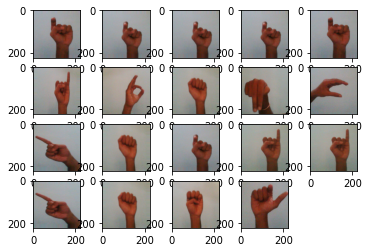

In [ ]:
x_batch, y_batch = train_generator.next()

fig=plt.figure()
columns = 5
rows = 4
for i in range(1, columns*rows):
    num = np.random.randint(batch_size)
    image = x_batch[num].astype(np.int32)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
plt.show()

In [ ]:
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import GlobalAveragePooling2D

In [ ]:
#Create model

input_shape = [244,244,3]
output_shape = 28

input = Input(shape=(input_shape[0], input_shape[1],input_shape[2]))

#'''block_1'''
b1_cnv2d_1 = Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding='same',
                 use_bias=False, name='b1_cnv2d_1', kernel_initializer='normal')(input)
b1_relu_1 = ReLU(name='b1_relu_1')(b1_cnv2d_1)
b1_bn_1 = BatchNormalization(epsilon=1e-3, momentum=0.999, name='b1_bn_1')(b1_relu_1)  # size: 14*14

b1_cnv2d_2 = Conv2D(filters=32, kernel_size=(1, 1), strides=(2, 2), padding='same',
                    use_bias=False, name='b1_cnv2d_2', kernel_initializer='normal')(b1_bn_1)
b1_relu_2 = ReLU(name='b1_relu_2')(b1_cnv2d_2)
b1_out = BatchNormalization(epsilon=1e-3, momentum=0.999, name='b1_out')(b1_relu_2)  # size: 14*14

#'''block 2'''
b2_cnv2d_1 = Conv2D(filters=32, kernel_size=(1, 1), strides=(1, 1), padding='same',
                    use_bias=False, name='b2_cnv2d_1', kernel_initializer='normal')(b1_out)
b2_relu_1 = ReLU(name='b2_relu_1')(b2_cnv2d_1)
b2_bn_1 = BatchNormalization(epsilon=1e-3, momentum=0.999, name='b2_bn_1')(b2_relu_1)  # size: 14*14

b2_add = add([b1_out, b2_bn_1])  #

b2_cnv2d_2 = Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same',
                    use_bias=False, name='b2_cnv2d_2', kernel_initializer='normal')(b2_add)
b2_relu_2 = ReLU(name='b2_relu_2')(b2_cnv2d_2)
b2_out = BatchNormalization(epsilon=1e-3, momentum=0.999, name='b2_bn_2')(b2_relu_2)  # size: 7*7

#'''block 3'''
b3_cnv2d_1 = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same',
                    use_bias=False, name='b3_cnv2d_1', kernel_initializer='normal')(b2_out)
b3_relu_1 = ReLU(name='b3_relu_1')(b3_cnv2d_1)
b3_bn_1 = BatchNormalization(epsilon=1e-3, momentum=0.999, name='b3_bn_1')(b3_relu_1)  # size: 7*7

b3_add = add([b2_out, b3_bn_1])  #

b3_cnv2d_2 = Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same',
                    use_bias=False, name='b3_cnv2d_2', kernel_initializer='normal')(b3_add)
b3_relu_2 = ReLU(name='b3_relu_2')(b3_cnv2d_2)
b3_out = BatchNormalization(epsilon=1e-3, momentum=0.999, name='b3_out')(b3_relu_2)  # size: 3*3

#'''block 4'''
b4_avg_p = GlobalAveragePooling2D()(b3_out)
output = Dense(output_shape, name='model_output', activation='softmax',
               kernel_initializer='he_uniform')(b4_avg_p)

model = Model(input, output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 b1_cnv2d_1 (Conv2D)            (None, 122, 122, 16  432         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 b1_relu_1 (ReLU)               (None, 122, 122, 16  0           ['b1_cnv2d_1[0][0]']             
                                )                                                             

In [ ]:
# Compile the model
from tensorflow.keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

# Start the training process
history = model.fit(train_generator, validation_data= val_generator, epochs = 10)

Epoch 1/10
7257/7257 [==============================] - 32152s 4s/step - loss: 1.1918 - accuracy: 0.6804 - val_loss: 2.3147 - val_accuracy: 0.3205
Epoch 2/10
7257/7257 [==============================] - 4500s 620ms/step - loss: 0.4512 - accuracy: 0.8954 - val_loss: 0.6376 - val_accuracy: 0.7887
Epoch 3/10
7257/7257 [==============================] - 4618s 636ms/step - loss: 0.2379 - accuracy: 0.9526 - val_loss: 0.9050 - val_accuracy: 0.6770
Epoch 4/10
7257/7257 [==============================] - 4725s 651ms/step - loss: 0.1463 - accuracy: 0.9744 - val_loss: 1.5959 - val_accuracy: 0.5668
Epoch 5/10
7257/7257 [==============================] - 4754s 655ms/step - loss: 0.0997 - accuracy: 0.9842 - val_loss: 0.9247 - val_accuracy: 0.7054
Epoch 6/10
7257/7257 [==============================] - 4765s 657ms/step - loss: 0.0720 - accuracy: 0.9895 - val_loss: 0.2903 - val_accuracy: 0.9129
Epoch 7/10
7257/7257 [==============================] - 4781s 659ms/step - loss: 0.0560 - accuracy: 0.9925 -

TypeError: ignored

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()